In [1]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import tensorflow

from yolo7_face.models.experimental import attempt_load
from yolo7_face.utils.general import check_img_size, non_max_suppression, scale_coords
from yolo7_face.utils.datasets import letterbox
from yolo7_face.utils.plots import plot_one_box

2023-12-07 11:23:25.648895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 11:23:26.284242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 11:23:26.284547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 11:23:26.285699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 11:23:26.529870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [19]:
# !pip install keras-flops
# Error: KeyError: "Registering two statistical functions with name 'AddV2,flops'!

In [22]:
from tensorflow.keras.applications import EfficientNetV2B3

efficient_net = EfficientNetV2B3(weights='imagenet',
                                 include_top=False,
                                 input_shape=(64, 64, 3),
                                 include_preprocessing=True)

In [23]:
net_flops(efficient_net, table=True)

               Layer Name |      Input Shape |     Output Shape |      Kernel Size |          Filters | Strides |  FLOPS
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  input_4 |      [64, 64, 3] |      [64, 64, 3] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
              rescaling_3 |     ['', '', ''] |     ['', '', ''] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
          normalization_3 |     ['', '', ''] |     ['', '', ''] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
                stem_conv |      [64, 64, 3] |     [32, 32, 40] |           (3, 3) |               40 | (2, 2) | 2211840.0000
                  stem_bn |     [32, 32, 40] |     [32, 32, 40] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
          stem_activation |     [32, 32, 40] |     [32, 32, 40] |           [0, 0] |           [0, 0] 

In [10]:
import keras

model = keras.models.load_model('../models/efficientnet_v2_b3/orig/efficientnetv2_b3_orig6.h5')

In [14]:
from get_keras_flops import net_flops


net_flops(model, table=True)

               Layer Name |      Input Shape |     Output Shape |      Kernel Size |          Filters | Strides |  FLOPS
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        efficientnetv2-b3 |     ['', '', ''] |     ['', '', ''] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
                  flatten |     [2, 2, 1536] |             6144 |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
KerasTensor(type_spec=TensorSpec(shape=(None, 6144), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
                    dense |             6144 |              [2] |           [0, 0] |           [0, 0] | [1, 1] | 24576.0000

Total FLOPS (x 10^6): 0.02457600


Total MACCs: 12288.00000000



In [54]:
def preprocess_yolo_face_input(image: np.ndarray, img_size: int, stride: int):
    prep_img = letterbox(image, img_size, stride=stride, auto=False)[0]
    
    # Convert BGR to RGB, to shape 3 x img_size x img_size
    prep_img = prep_img[:, :, ::-1].transpose(2, 0, 1)
    prep_img = np.ascontiguousarray(prep_img)

    prep_img = torch.from_numpy(prep_img).to('cpu')
    prep_img = prep_img.float() / 255
    prep_img = prep_img.unsqueeze(0)

    return prep_img

def detect_faces(image: np.ndarray,
                 weights: str = '../models/yolov7-lite-s.pt',
                 img_size: int = 640,
                 conf_threshold: float = 0.25,
                 iou_threshold: float = 0.45):

    model = attempt_load(weights, map_location='cpu')
    stride = int(model.stride.max())
    img_size = check_img_size(img_size, s=stride)

    prep_img = preprocess_yolo_face_input(image, img_size, stride)

    prediction = model(prep_img, augment=False)[0]
    prediction = non_max_suppression(prediction, conf_threshold, iou_threshold, kpt_label=5)

    detection = prediction[0]
    scale_coords(prep_img.shape[2:], detection[:, :4], image.shape, kpt_label=False)

    detection = np.array(detection)
    bounding_boxes = detection[:, :4].astype(int)
    confidences = detection[:, 4]
    return bounding_boxes, confidences

In [42]:
def plot_mask_detection_results(image: np.ndarray,
                                bounding_boxes: np.ndarray,
                                mask_labels: np.ndarray):

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for xyxy, mask_label in zip(bounding_boxes, mask_labels):
        color = (0, 255, 0) if mask_label > 0.5 else (255, 0, 0)
        plot_one_box(xyxy, image, color, steps=3, orig_shape=image.shape[:2])

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [68]:
def classify_faces(image: np.ndarray,
                   bounding_boxes: np.ndarray,
                   weights: str = '../models/efficientnet_v2_b3.h5'):
    
    model = tensorflow.keras.models.load_model(weights)

    face_images = []
    for x_min, y_min, x_max, y_max in bounding_boxes:
        face_img = image[y_min: y_max, x_min: x_max]
        face_img = cv2.resize(face_img, (64, 64))
        face_images.append(face_img)

    face_images = np.reshape(face_images, [-1, 64, 64, 3])
    mask_labels = model.predict(face_images, verbose=0)[:, 0]

    return mask_labels

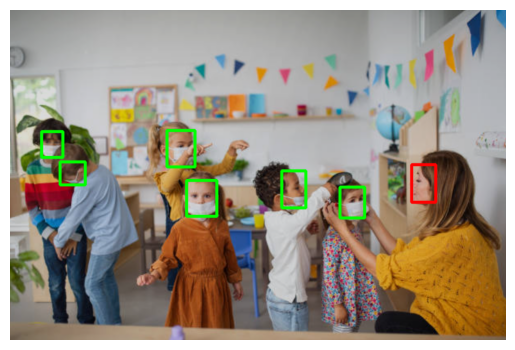

In [67]:
image = cv2.imread('sample_image1.png')
bounding_boxes, confidences = detect_faces(image)
mask_labels = classify_faces(image, bounding_boxes)
plot_mask_detection_results(image, bounding_boxes, mask_labels)

In [21]:
%matplotlib inline